In [4]:
import pandas as pd
import numpy as np
import random as rnd


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [26]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 5              6         0       3   
 6              7         0       1   
 7              8         0       3   
 8              9         1       3   
 9             10         1       2   
 10            11         1       3   
 11            12         1       1   
 12            13         0       3   
 13            14         0       3   
 14            15         0       3   
 15            16         1       2   
 16            17         0       3   
 17            18         1       2   
 18            19         0       3   
 19            20         1       3   
 20            21         0       2   
 21            22         1       2   
 22            23         1       3   
 23            24         1       1   
 24            25        

In [74]:
print(train_df.columns.values)

# Miramos los datos, para ver que si hay nulos o datos que rellenar, como la edad y la cabina en este caso
train_df.isnull().sum()

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'Ticket' 'Fare'
 'Embarked' 'FamilySize']


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
Ticket           0
Fare             0
Embarked         0
FamilySize       0
dtype: int64

In [52]:
# Faltan muchos datos de edad y cabina por rellenar, ademas de 2 embarcos
print (train_df.info())
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null category
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: category(1), float64(1), int64(6), object(4)
memory usage: 77.5+ KB
None


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000


Como faltan mas de la mitad de los datos de la cabina y no contienen informacion util, se puede descartar esta feature.

Tambien vamos a quitar ticket, porque no hay relacion ninguna entre los nombres de los tickets

In [62]:
train_df, test_df = train_df.drop(['Cabin', 'Ticket'], axis=1), test_df.drop(['Cabin', 'Ticket'], axis=1)

ValueError: labels ['Cabin'] not contained in axis

In [54]:
# Sacamos la descripcion de los valores que son Strings (object)
train_df.describe(include=['O'])

,Name,Ticket,Embarked
count,891,891,891
unique,891,681,3
top,"Hays, Miss. Margaret Bechstein",347082,S
freq,1,7,646


## Analisis a primera vista de los datos

- Hay que rellenar los datos que faltan para poder usarlo en los algoritmos de entrenamiento
- Hay que pasar todos los strings a valores numericos para poder usarlo en los algoritmos de entrenamiento
- Hay que descartar features que sean inutiles o crear nuevas features a partir de las nuevas para entrenar

# Visualizacion grafica de la relacion entre las features

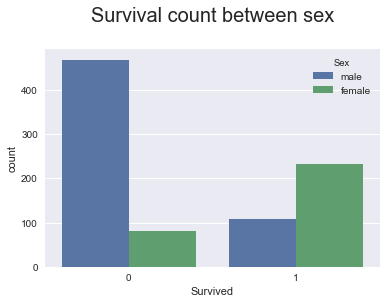

In [22]:
plt.title('Survival count between sex', size=20, y=1.1)
sns.countplot(x = 'Survived', hue='Sex', data=train_df)
#Hay una gran correlacion entre el sexo y la supervivencia

In [49]:
# Pasamos el sexo de string a un int, 1 para hombre y 0 para mujer
for df in [train_df, test_df]:
    df['Sex'] = df['Sex'].apply(lambda x : 1 if x == 'male' else 0)

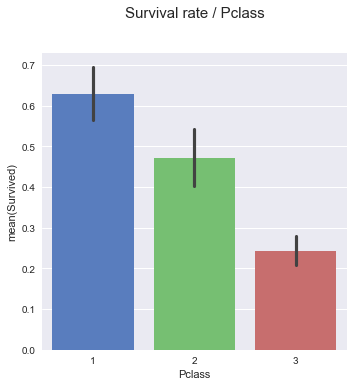

In [37]:
# Hay relacion directa entre la clase y la supervivencia
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.title('Survival rate / Pclass', size=15, y=1.1)
sns.barplot(x='Pclass', y = 'Survived', data=train_df, palette='muted')

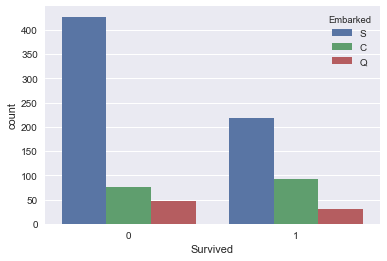

In [35]:
sns.countplot(x = 'Survived', hue='Embarked', data=train_df)
# Tambien hay una ligera correlacion con el lugar de embarque

Como faltan 2 datos de embarque de 2 personas y usaremos la feature, rellenamos con S porque 
es donde la mayoria de las personas lo han hecho y hay menos riesgo de falsear las features.
Tambien pasamos de S,C,Q a valores enteros para entrenarlos


In [34]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')
for dt in [train_df, test_df]:
    dt['Embarked'] = dt['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [41]:
#Rellenamos el unico valor que falta de fare
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

In [139]:
# Transformamos los valores continuos de fare en valores discretos, agrupando los rangos en 4 grupos, del 0 al 3
for df in [train_df, test_df]:
    df['Fare'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3])

train_df.head(5)

ValueError: Bin edges must be unique: array([ 0.  ,  0.  ,  1.  ,  2.75,  3.  ])

Como Parch es la abreviacion de 'parent/children', sumado y SibSp es la abreviacion de 'sibling/spouse' sumados, se pueden juntar estas 2 features en una sola que representen el tamaño de la familia que tiene esa persona, incluyendola.
Sacamos la grafica para ver la relacion que hay

In [55]:
for df in [train_df, test_df]:
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

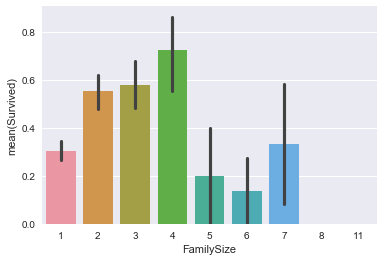

In [56]:
sns.barplot(x='FamilySize', y='Survived' , data=train_df)


De esta grafica podemos ver que las personas con 2,3 o 4 de tamaño familiar, tenian mas posibilidades de supervivencia
Asi que vamos a simplicar esta nueva feature en 0 si esta fuera de 2,3 o 4 miembros en el barco y 1 si lo esta.
Con esto las features Parch y SibSp no hacen falta

In [57]:
def filter_family_size(x):
    if x == 1:
        return 0
    elif x < 4:
        return 1
    else:
        return 0

for df in [train_df, test_df]:
    df['FamilySize'] = df['FamilySize'].apply(filter_family_size)


In [60]:
train_df = train_df.drop(['Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp'], axis=1)

ValueError: labels ['Parch' 'SibSp'] not contained in axis

In [165]:
train_df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,FamilySize,NameLength,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare_female,Title_Rare_male
0,1,0,3,1,2,A/5 21171,0,0,1,23,0,0,1,0,0,0
1,2,1,1,0,3,PC 17599,3,1,1,51,0,0,0,1,0,0
2,3,1,3,0,2,STON/O2. 3101282,1,0,0,22,0,1,0,0,0,0
3,4,1,1,0,3,113803,3,0,1,44,0,0,0,1,0,0
4,5,0,3,1,3,373450,1,0,0,24,0,0,1,0,0,0


# Rellenar la edad
La forma mas precisa de hacerlo es usando la mediana y la correlaciones que la edad tiene con otras features,en este caso las mas correladas son el genero y pclass, como se ve en el diagrama de calor de abajo.

A partir de la edad he creado una nueva feature con el rango de edades, para ver la supervivencia entre rangos

El numero de datos Age sin rellenar:  0


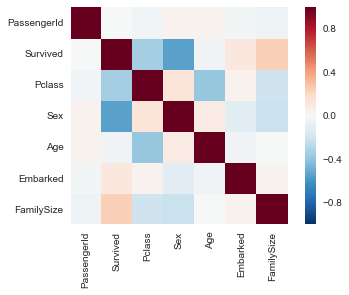

In [155]:
corrmat = train_df.corr()
sns.heatmap(corrmat, square=True)
print ("El numero de datos Age sin rellenar: ",train_df['Age'].isnull().sum())

In [ ]:
plt.title('Distribucion de la edad original', size=20, y=1.1)
sns.distplot(train_df['Age'].dropna())

In [129]:
#Rellenamos los campos edad vacios
guess_ages = np.zeros((2,3))
for dataset in [train_df, test_df]:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

print ("El numero de datos Age sin rellenar: ",train_df['Age'].isnull().sum())

El numero de datos Age sin rellenar:  0


Al haber introducido los nuevos datos sobre la media, la distribucion sigue siendo igual a antes de introducirlos, pero con un repunte de datos en la zona de la mediana

F:\Archivos de Programa\Anaconda3_4.3.1\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


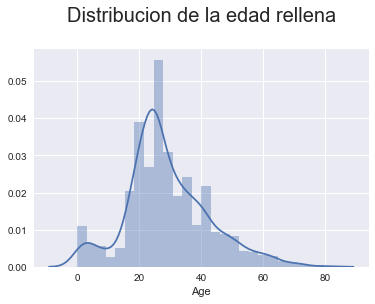

In [135]:
plt.title('Distribucion de la edad rellena', size=20, y=1.1)
sns.distplot(train_df['Age'])

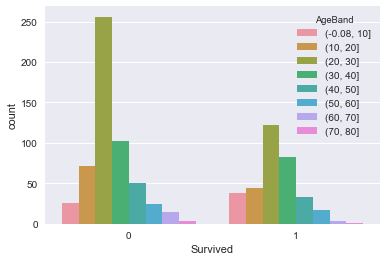

In [144]:
#Creamos la nueva feature y la mostramos
train_df['AgeBand'] = pd.cut(train_df['Age'], 8)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
sns.countplot(x='Survived', hue='AgeBand' , data=train_df)

Convertimos el campo edad en valores de 0 al 7 siguiendo la feature banda de edades que hemos creado antes, con este cambio, banda de edades es una feature que no necesitamos ya

In [147]:
for dataset in [train_df, test_df]:    
    dataset.loc[ dataset['Age'] <= 10, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 20), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 30), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 60) & (dataset['Age'] <= 70), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 70, 'Age'] = 7
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,FamilySize,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",1,2,A/5 21171,0,0,1,"(20, 30]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,PC 17599,3,1,1,"(30, 40]"
2,3,1,3,"Heikkinen, Miss. Laina",0,2,STON/O2. 3101282,1,0,0,"(20, 30]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3,113803,3,0,1,"(30, 40]"
4,5,0,3,"Allen, Mr. William Henry",1,3,373450,1,0,0,"(30, 40]"


In [151]:
train_df = train_df.drop(['AgeBand'], axis=1)


ValueError: labels ['AgeBand'] not contained in axis

# Nombre

In [158]:
# Filter the name
def get_title(x):
    y = x[x.find(',')+1:].replace('.', '').replace(',', '').strip().split(' ')
    if y[0] == 'the':    # Search for the countess
        title = y[1]
    else:
        title = y[0]
    return title

def filter_title(title, sex):
    if title in ['Countess', 'Dona', 'Lady', 'Jonkheer', 'Mme', 'Mlle', 'Ms', 'Capt', 'Col', 'Don', 'Sir', 'Major', 'Rev', 'Dr']:
        if sex:
            return 'Rare_male'
        else:
            return 'Rare_female'
    else:
        return title

for df in [train_df, test_df]:
    df['NameLength'] = df['Name'].apply(lambda x : len(x))
    df['Title'] = df['Name'].apply(get_title)
    
train_df.groupby('Title')['PassengerId'].count().sort_values(ascending=False)

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Countess      1
Don           1
Sir           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Capt          1
Name: PassengerId, dtype: int64

Title
Mr             517
Miss           182
Mrs            125
Master          40
Rare_male       20
Rare_female      7
Name: PassengerId, dtype: int64

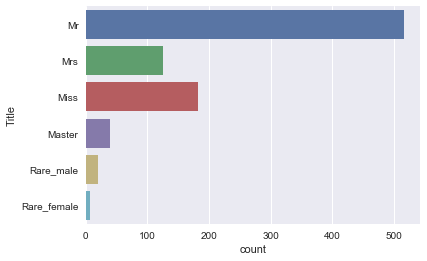

In [161]:
#Quitamos los titulos especiales y los agrupamos en categorias mas concretas
for df in [train_df, test_df]:
    df['Title'] = df.apply(lambda x: filter_title(x['Title'], x['Sex']), axis=1)

sns.countplot(y=train_df['Title'])
train_df.groupby('Title')['PassengerId'].count().sort_values(ascending=False)

In [164]:
train_df = pd.get_dummies(train_df, columns=['Title'])
test_df = pd.get_dummies(test_df, columns=['Title'])

train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)


# Eleccion del Modelo